<a href="https://colab.research.google.com/github/Matheuss1/artificial-intelligence-and-what-is-behind/blob/assignment-02/linear_regression_assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarefa \#2**: Machine Learning MC886/MO444
##**Regressão Linear**##

Universidade Estadual de Campinas (Unicamp)

Instituto de Computação (IC)

Prof. Marcelo Reis



In [ ]:
# TODO: RA & Name 
print('241882: ' + 'Matheus Silva de Deus')
print('186447: ' + 'Renan Borges Alves')

241882: Matheus Silva de Deus
186447: Renan Borges Alves


## Objective: Predict life expectancy. 

Explore **linear regression** alternatives and come up with the best possible model to the problems, avoiding overfitting. In particular, predict the **Life expectancy** from their attributes.

## Dataset

The purpose of this dataset is to do health data analysis. The dataset related to life expectancy, health factors for 193 countries was collected from the same WHO data repository website and their corresponding economic data were collected from the United Nations website. Among all categories of health-related factors, only the critical factors that are most representative were chosen. All predictor variables were then divided into several broad categories: Immunization-related factors, Mortality factors, Economic factors, and Social factors.

Dataset Information: You should respect the following traininig/test split: 2056 training examples, and 882 test examples.

There are 22 attributes as follows: 

Data Dictionary

- Country	
- Year	
- Status		
- Adult Mortality	
- infant deaths	
- Alcohol	
- percentage expenditure	
- Hepatitis B	
- Measles	
- BMI	
- under-five deaths	
- Polio	
- Total 
- expenditure	
- Diphtheria	
- HIV/AIDS	
- GDP	
- Population	
- thinness  1-19 years	
- thinness 5-9 years	
- Income composition of resources	Schooling

- **Life expectancy**


The data is available at
- train: https://tinyurl.com/5374623f
- test: https://tinyurl.com/mtdkjf55


## Atividades

1. (5 pontos) Faça a Regressão Linear. Você deve implemetar a sua própria solução e comparar com ```sklearn.linear_model.SGDRegressor``` (modelo linear calculado com gradiente descendente estocástico da biblioteca [scikit-learn](http://scikit-learn.org)).
Não esqueça que o conjunto de testes NÃO deve ser utilizado para o **treinamento** do modelo.

**Dica: Verifique o conjunto de dados. Existem outliers? Estão faltando valores em alguns campos? Como utilizar variáveis categóricas?**


In [1]:
#import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline


In [2]:
# Tools to import the data to be used in this analysis

class GoogleDriveSheetDataImporter:
  @staticmethod
  def importData(sheet_id):
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv"

    return pd.read_csv(url)

TRAINING_DATA_SHEET_ID = '1ejB4RtHX6ma0XK51I6f_7AtDblKivlOtzSkxitdZYtA'
TEST_DATA_SHEET_ID = '1PrY9blDscKw5gWTyA3S34Gj3H5rRpuUU_b9rhVFsPQc'

In [3]:
# Tools to preprocess data
from sklearn.preprocessing import StandardScaler

def convertStringDottedNumberToPythonInt(numberToConvert):
  if pd.isna(numberToConvert):
    return numberToConvert
    
  return int(numberToConvert.replace('.',''))

  
def applyToColumn(df, columnName, func):
  df[columnName] = df[columnName].apply(func)
  return df


def replaceMissingValues(df):
  numeric_columns = df.select_dtypes(include=np.number).columns

  return  df[numeric_columns].fillna(df.mean())


def getXValuesWithBiasIncludedInWeightsVector(X):
  rows_number = len(X)

  return np.c_[np.ones(rows_number), X]


def getValuesAndLabels(dataframe):
  X_values = dataframe.loc[:, dataframe.columns != 'Life expectancy'].values
  Y_values = dataframe['Life expectancy'].values
  return X_values, Y_values

class FeaturesScaler():
  def __init__(self):
    self.scaler = StandardScaler()

  def fit(self, data):
    return self.scaler.fit(data)

  def transform(self, data):
    return self.scaler.transform(data)

  def fit_transform(self, data):
    return self.scaler.fit_transform(data)


In [4]:
# Get the train and test dataframes

train_df = GoogleDriveSheetDataImporter.importData(TRAINING_DATA_SHEET_ID)
test_df = GoogleDriveSheetDataImporter.importData(TEST_DATA_SHEET_ID)

In [5]:
# Transform numbers in string format to python number type

train_df = applyToColumn(train_df, 'percentage expenditure', convertStringDottedNumberToPythonInt)
train_df = applyToColumn(train_df, 'GDP', convertStringDottedNumberToPythonInt)

test_df = applyToColumn(test_df, 'percentage expenditure',convertStringDottedNumberToPythonInt)
test_df = applyToColumn(test_df, 'GDP', convertStringDottedNumberToPythonInt)

# Drop features (better results are given without them)
COLUMNS_TO_DROP = ['Country', 'Status', 'Diphtheria']


train_df = train_df.drop(columns=COLUMNS_TO_DROP)

test_df = test_df.drop(columns=COLUMNS_TO_DROP)

# Replace dataframe missing values (NaN)

train_df = replaceMissingValues(train_df)
test_df = replaceMissingValues(test_df)


# Normalize dataframe data

scaler = FeaturesScaler()

train_df = pd.DataFrame(scaler.fit_transform(train_df),columns=train_df.columns,index=train_df.index)
test_df = pd.DataFrame(scaler.transform(test_df),columns=test_df.columns,index=test_df.index)

In [6]:
X_train, y_train = getValuesAndLabels(train_df)

X_test, y_test = getValuesAndLabels(test_df)

# Add a column of ones, to use bias inside weights vector
X_train = getXValuesWithBiasIncludedInWeightsVector(X_train)

X_test = getXValuesWithBiasIncludedInWeightsVector(X_test)


In [7]:
rng = np.random.RandomState(0)

# Mean Squared Error
def mse_loss(y_pred, y_true):
    np_y_pred = np.array(y_pred)
    np_y_true = np.array(y_true)

    return np.mean((np_y_true - np_y_pred)**2)


def plot_history(model):
    plt.plot(model.history)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.show()


class SGDRegression():
    def __init__(self, learning_rate, max_iter):
        self.max_iter = max_iter  # maximo de iteracoes
        self.alpha = learning_rate  # taxa de aprendizado
        self.ws = None  # pesos

    def predict(self, X):
        return X @ self.ws

    # using sum of squares error to calculate the gradient
    def update_weights(self, y_pred, target, sample):
        n_weights = len(self.ws)
        stochastic_gradient = []

        for i in range(n_weights):
            wi_derivative = -2 * sample[i] * (y_pred - target)

            stochastic_gradient.append(wi_derivative)

        self.ws = self.ws - (self.alpha * np.array(stochastic_gradient))

    def fit(self, X, y):
        if self.ws is None:
            # init random weights
            ws = rng.randn(X.shape[1])
            self.ws = ws
        assert X.shape[0] == y.shape[0]

        history = []  # lista para guardar os valores de loss
        for i in range(self.max_iter):
            X, y = shuffle(X, y, random_state=0)
            avg_loss = []
            for sample, target in zip(X, y):
                y_pred = self.predict(sample)
                loss = mse_loss(y_pred, target)
                avg_loss.append(loss)
                self.update_weights(y_pred, target, sample)
            history.append((sum(avg_loss)/len(avg_loss)))
        self.history = history


In [8]:
lr = 1e-8
max_iter = 1000
sgd_linear = SGDRegression(learning_rate=lr, max_iter=max_iter)
sgd_linear.fit(X_train, y_train)
print('W = ', sgd_linear.ws)

W =  [ 1.83810213  0.4013455   1.06628751  2.38614656  1.90538751 -1.02140624
  0.95832275 -0.0858433  -0.16521704  0.55705062  0.1203806   1.50379316
  0.84055456  0.12128974  0.51587267  0.44087417  1.61395217 -0.23746075
  0.27709653]


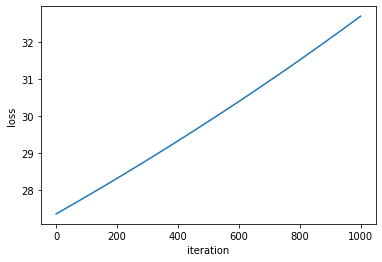

In [9]:
# Loss evolution over time
plot_history(sgd_linear)

In [10]:
# MSE loss in test set
y_pred = sgd_linear.predict(X_test)

mse_loss(y_pred, y_test)

40.628200274998534

In [11]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(max_iter=1000, tol=1e-3, shuffle=True)

reg.fit(X_train, y_train)

print('W = ', reg.coef_)

W =  [ 0.00072284  0.01871342 -0.30713261  0.05946327  0.05917164  0.01872064
 -0.02177938 -0.04869165  0.10314426 -0.07955551  0.1130806   0.02222516
 -0.25824039 -0.00416919  0.01331148 -0.03007913  0.03939833  0.066627
  0.30658461]


In [12]:
# MSE loss in test set using sklearn SGDRegressor
y_pred = reg.predict(X_test)

mse_loss(y_pred, y_test)

0.21658170043244068


>**Quais são as suas conclusões? (1-2 parágrafos)**

É notável, no modelo criado por nós, que conforme evoluimos o número de iterações, o valor do loss aumenta
cada vez mais, aparententando, inclusive, seguir um modelo de crescimento semelhante a uma reta, dentro do intervalo de learning rate e iterações testado. Logo, é possível perceber que o que mais influencia na variação do loss é o valor definido para o Learning Rate, que se utilizado um valor um pouco maior, começa a gerar valores de loss absurdamente altos, algo que talvez pudesse ser melhorado caso tivessemos utilizados uma tática de learning rate adaptativo.

Por fim, nota-se que o uso do modelo implementado utilizando a biblioteca do sklearn possui um desempenho absurdamente melhor em comparação ao criado por nós, tanto em questão de perfomance, quanto na métrica de loss que foi utilizada, o que é algo esperado, uma vez que se observada a documentação do sklearn, podemos notar que os métodos de implementação utilizados são muito mais robustos.





2. (2 points) Treine o modelo de regressão linear otimizado com Gradiente Descendente (GD) com 3 taxas de aprendizado diferentes. Compare os resultados dos modelos de GD com a solução com a equação normal (pseudo-inversa). 

In [ ]:
lr1 = 1e-6
max_iter = 1000
sgd_linear_lr1 = SGDRegression(learning_rate=lr1, max_iter=max_iter)
sgd_linear_lr1.fit(X_train, y_train) #treinamento
print('Taxa de aprendizado = ', lr1, ' W = ', sgd_linear_lr1.ws)

lr2 = 1e-8
max_iter = 1000
sgd_linear_lr2 = SGDRegression(learning_rate=lr2, max_iter=max_iter)
sgd_linear_lr2.fit(X_train, y_train) #treinamento
print('Taxa de aprendizado = ', lr2, ' W = ', sgd_linear_lr2.ws)

lr3 = 1e-10
max_iter = 1000
sgd_linear_lr3 = SGDRegression(learning_rate=lr3, max_iter=max_iter)
sgd_linear_lr3.fit(X_train, y_train) #treinamento
print('Taxa de aprendizado = ', lr3, ' W = ', sgd_linear_lr3.ws)

Taxa de aprendizado =  1e-06  W =  [-1.22906596e+02 -2.51253113e+05  7.25771486e+05  1.02535147e+06
 -7.24728296e+05  5.67782859e+02 -4.86268290e+05  6.37254216e+05
 -9.79288207e+05  1.04064804e+06 -7.37136185e+05 -4.62262603e+05
  4.71630785e+05  4.14482701e+04  4.68280892e+05  1.05070796e+06
  1.05977520e+06 -6.96510177e+05 -1.01303567e+06]
Taxa de aprendizado =  1e-08  W =  [ 0.73623307  0.01411244  1.83866418  0.11579993  0.41134315  1.97621344
 -1.38481212 -1.32584361  0.97753466 -1.18586687  1.99687249 -0.42416229
 -0.72776831  2.02112183  1.53251805  1.943205    0.97168007 -0.88830449
  1.94480765]
Taxa de aprendizado =  1e-10  W =  [-0.2681136   0.80269681  0.94782939 -0.15458683  0.61396346  0.92260269
  0.37628578 -1.09953129  0.2979848   1.32682115 -0.69500933 -0.14977031
 -0.43494664  1.85006366  0.67272456  0.40767799 -0.76977529  0.53912428
 -0.67478972]


In [ ]:
# Calcule e compare o MSE no conjunto de testes para cada modelo
y_pred_lr1 = sgd_linear_lr1.predict(X_test)
print('MSE LR1 = ', mse_loss(y_pred_lr1, y_test))

y_pred_lr2 = sgd_linear_lr2.predict(X_test)
print('MSE LR2 = ', mse_loss(y_pred_lr2, y_test))

y_pred_lr3 = sgd_linear_lr3.predict(X_test)
print('MSE LR3 = ', mse_loss(y_pred_lr3, y_test))

MSE LR1 =  49463026852018.81
MSE LR2 =  30.003250868798748
MSE LR3 =  12.079448490338336


Regressão linear através de Equação Normal

In [13]:
class NERegression():
    def __init__(self):
      self.ws = None #pesos
    
    def predict(self, X):
      return X.dot(self.ws)

    def fit(self, X, y):
      self.ws = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)


In [14]:
ne = NERegression()
ne.fit(X_train, y_train)
print("W = ", ne.ws)

W =  [ 6.15122103e-16  2.34093543e-02 -3.04013226e-01  1.29170777e+00
  8.13649557e-02  2.35068569e-02 -1.56797315e-02 -3.47664398e-02
  1.13029199e-01 -1.32136802e+00  1.04332073e-01  1.92672145e-02
 -2.59061797e-01 -6.62127218e-03  2.00427413e-03 -3.16977422e-02
  3.34816665e-02  7.06640733e-02  3.02588343e-01]


In [15]:
y_pred_normal = ne.predict(X_test)

mse_loss(y_pred_normal, y_test)

0.1999626940492603

   > **Quais são as suas conclusões? (1-2 parágrafos):**


Pode-se notar, inicialmente, que o MSE do modelo com otimização feita pelo gradiente é muito dependente do valor definido para a taxa de aprendizado. Taxas relativamente altas levam a valores de MSE extremamente altos, fazendo com que o resultado obtido não seja útil para nada. Já utilizando taxas mais baixas, podemos notar que o MSE se torna bem menor, mas que ainda é muito maior do que utilizando a equação normal.

A equação normal nos traz um valor que pode ser considerado ótimo, com um MSE muito próximo de zero, o que nos leva a crer que possuimos um ótimo modelo de regressão linear.

3. (2 points) Às vezes, funções mais complexas geram melhores predições. Desenvolva e avalie um modelo de regressão polinomial.



In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class PolyFeatures():
    def __init__(self, degree):
      self.degree = degree #grau da nova matriz X

    def transform(self, X):
      poly_features = PolynomialFeatures(self.degree)

      X_poly = poly_features.fit_transform(X)
      return X_poly

In [17]:
degree = 2 #escolha o grau da regressão polinomial
poly_feat = PolyFeatures(degree)
X_train_poly = poly_feat.transform(X_train)

In [18]:
lr = 1e-15 #substitua por uma taxa de aprendizado válida
max_iter = 10 #substitua por um número máximo de iterações válido
sgd_poly = SGDRegression(learning_rate=lr, max_iter=max_iter)
sgd_poly.fit(X_train_poly, y_train) #treinamento
print('W = ', sgd_poly.ws)

W =  [-0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502  2.26975462
 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877  0.15494743
  0.37816252 -0.88778575 -1.98079647 -0.34791215  0.15634897  1.23029068
  1.20237985 -0.38732682 -0.30230275 -1.04855297 -1.42001794 -1.70627019
  1.9507754  -0.50965218 -0.4380743  -1.25279536  0.77749036 -1.61389785
 -0.21274028 -0.89546656  0.3869025  -0.51080514 -1.18063219 -0.02818223
  0.42833187  0.06651722  0.3024719  -0.63432209 -0.36274117 -0.67246045
 -0.35955316 -0.81314628 -1.7262826   0.17742614 -0.40178094 -1.63019835
  0.46278226 -0.90729836  0.0519454   0.72909056  0.12898291  1.13940068
 -1.23482582  0.40234164 -0.68481009 -0.87079715 -0.57884966 -0.31155253
  0.05616534 -1.16514984  0.90082649  0.46566244 -1.53624369  1.48825219
  1.89588918  1.17877957 -0.17992484 -1.07075262  1.05445173 -0.40317695
  1.22244507  0.20827498  0.97663903  0.3563664   0.70657317  0.01050002
  1.78587049  0.12691209  0.40198936  1.883150

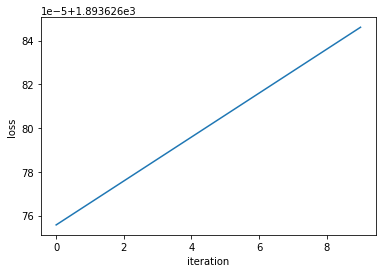

In [19]:
#Evolução da loss ao longo do tempo
plot_history(sgd_poly)

In [20]:
# EXTRA - apenas para meio de comparação com os modelos disponibilizados pelo sklearn

degree = 2 #escolha o grau da regressão polinomial
poly_feat = PolyFeatures(degree)
X_train_poly = poly_feat.transform(X_train)

pol_reg = LinearRegression()
pol_reg.fit(X_train_poly, y_train)

y_pred_pol = pol_reg.predict(poly_feat.transform(X_test))
mse_loss(y_pred_pol, y_test)

0.18196483135448274

\
 > **Quais as suas conclusões?(1-2 parágrafos):**

 


Avaliando o modelo de regressão aqui implementado, podemos notar que o uso de uma função mais complexa não necessariamente trouxe bons resultados. Pode-se notar que, utilizando o modelo criado por nós com a otimização pelo gradiente, a função de loss alcança valores muito altos, o que indica que nosso modelo não demonstra um bom desempenho com o uso desta estratégia.

Por outro lado, apenas como ponto de comparação extra, efetuamos o treinamento de um modelo utilizando ferramentas já disponibilizas pelo sklearn, para a execução de uma regressão linear, e, para este caso, podemos notar que o uso de uma função mais complexa traz ótimos resultados, mas que talvez não seja tão útil assim aumentar a complexidade da função, pois o valor fica bem próximo de quando se faz o uso da equação normal, ou do SGD disponibilizado pelo próprio sklearn e, além disso, se o grau da função for maior que 2, passamos a ter resultados ruins.

4. (1 point) Avalie os gráficos da função de custo vs. número de iterações no conjunto de treino. Quais conclusões você pode chegar a respeito dos modelos de GD ao analisar os gráficos?

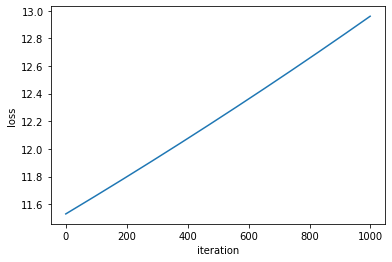

In [ ]:
#print('Função de custo vs. Numero de iterações GD linear')
plot_history(sgd_linear)

Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =   1e-06


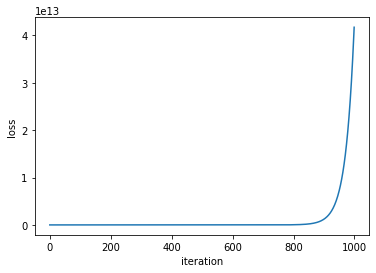

In [ ]:
print('Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =  ', lr1)
plot_history(sgd_linear_lr1)

Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =   1e-08


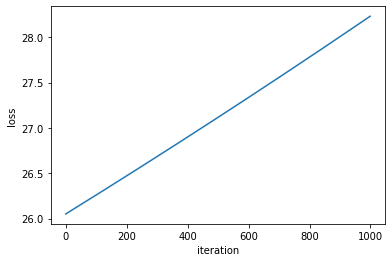

In [ ]:
print('Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =  ', lr2)
plot_history(sgd_linear_lr2)

Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =   1e-10


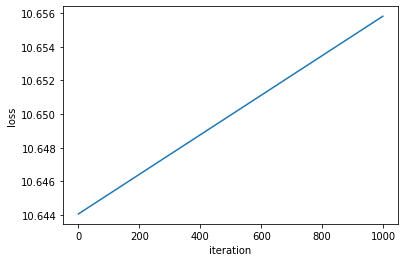

In [ ]:
print('Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =  ', lr3)
plot_history(sgd_linear_lr3)

Função de custo vs. Numero de iterações GD Polinomial


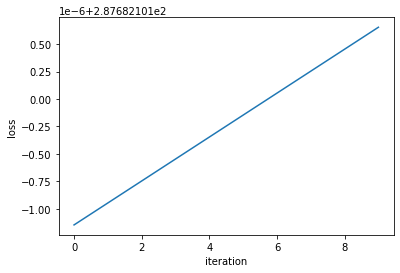

In [ ]:
print('Função de custo vs. Numero de iterações GD Polinomial')
plot_history(sgd_poly)

> **Escreva aqui suas conclusões (2-4 parágrafos)**


Inicialmente, é possível notar mais uma vez o efeito da taxa de learning rate para os modelos aqui implementados. Podemos avaliar tal parâmetro como o mais influente, pois ele afeta diretamente a evolução do loss ao longo das iterações. Pode ser notado que um valor maior para o learning rate leva a um valor de loss muito alto, e até de maneira extrema, em certos casos, como pode ser visto no modelo com lr1, que traz um loss com valores da ordem de 1e13.

Em modelos que se utilizam de um learning rate menor, obtemos melhores resultados. Como citado anteriormente, uma possível solução para evitar problemas com a taxa de aprendizado, seria utilizar um valor adaptativo ao longo das iterações.

Em suma, utilizando baixos valores de learning rate conseguimos resultados relativamente bons, que não chegam a ser tão precisos quanto quando fazemos uso da equação normal ou utilizamos o SGD já implementado pela biblioteca sklearn, mas que ainda assim podem ser bem úteis, com um loss na faixa de valor entre 10 e 11. Uma exceção, porém, é no caso da implementação do GD polinomial, que para o modelo implementado por nós gerou piores resultados quando tentamos aumentar a complexidade da função.

## Prazo: 19 de Abril, Terça-feira, 23:59

Política de penalidade para submissões atrasadas: Você não está sendo encorajada(o) a submeter o trabalho depois da data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:

- 20 de Abril 23:59 : nota * 0.75
- 21 de Abril 23:59 : nota * 0.5
- 22 de Abril 23:59 : nota * 0.25


## Submissão
- Submita seu notebook no Google Classroom. (Em português ou inglês).

- Apenas UMA pessoa da dupla precisa enviar o notebook.

- Não esqueça de colocar seus respectivos nomes & RAs.

- **Esta atividade NÃO é individual, deve ser realizada em dupla.**